## Sokoban analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
games_filtered = pd.read_csv('games.csv')
levels = pd.read_csv('levels.csv')

games_filtered.shape

(63, 5)

In [100]:



levels_filtered = levels[levels['game_id'].isin(games_filtered['id'])]


print(levels_filtered.shape)
print(levels.shape)



(519, 6)
(660, 6)


## Results overview

### Level attempts vs successes

15
13


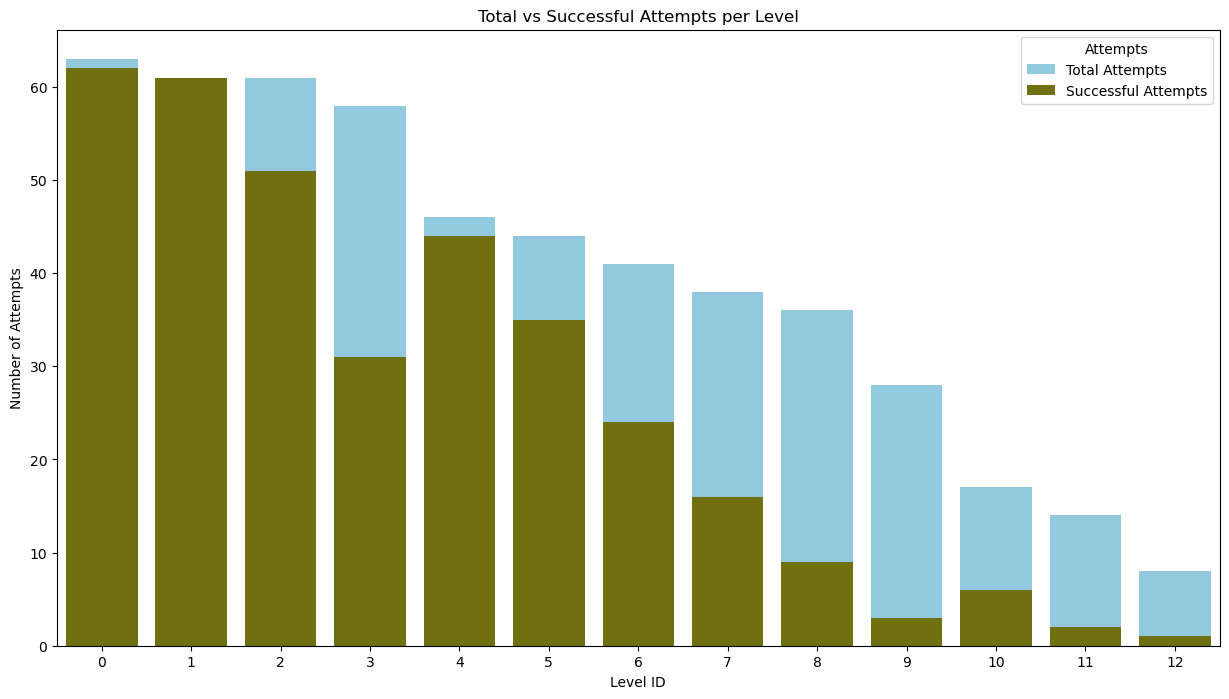

In [101]:
# Count total attempts per level

total_attempts = levels_filtered['level_id'].value_counts().reset_index()
total_attempts.columns = ['level_id', 'total_attempts']

# Count how many times the level was passed
passed_attempts = levels_filtered[(~levels_filtered['end_time'].isna()) & (levels_filtered['skipped'] != 't')]['level_id'].value_counts().reset_index()
passed_attempts.columns = ['level_id', 'passed_attempts']


unique_values_count = levels_filtered['level_id'].nunique()
passed_attempts_count = passed_attempts['level_id'].nunique()

print(unique_values_count)
print(passed_attempts_count)

# Merge the two dataframes
df = pd.merge(total_attempts, passed_attempts, on='level_id')

# Calculate success percentage
df['success_percentage'] = df['passed_attempts'] / df['total_attempts'] * 100

# Create a bar plot
plt.figure(figsize=(15,8))
p1 = sns.barplot(data=df, x='level_id', y='total_attempts', color='skyblue', label='Total Attempts')
p2 = sns.barplot(data=df, x='level_id', y='passed_attempts', color='olive', label='Successful Attempts')

plt.legend(title='Attempts')
plt.xlabel('Level ID')
plt.ylabel('Number of Attempts')
plt.title('Total vs Successful Attempts per Level')
plt.show()

## Levels ordered by success rate

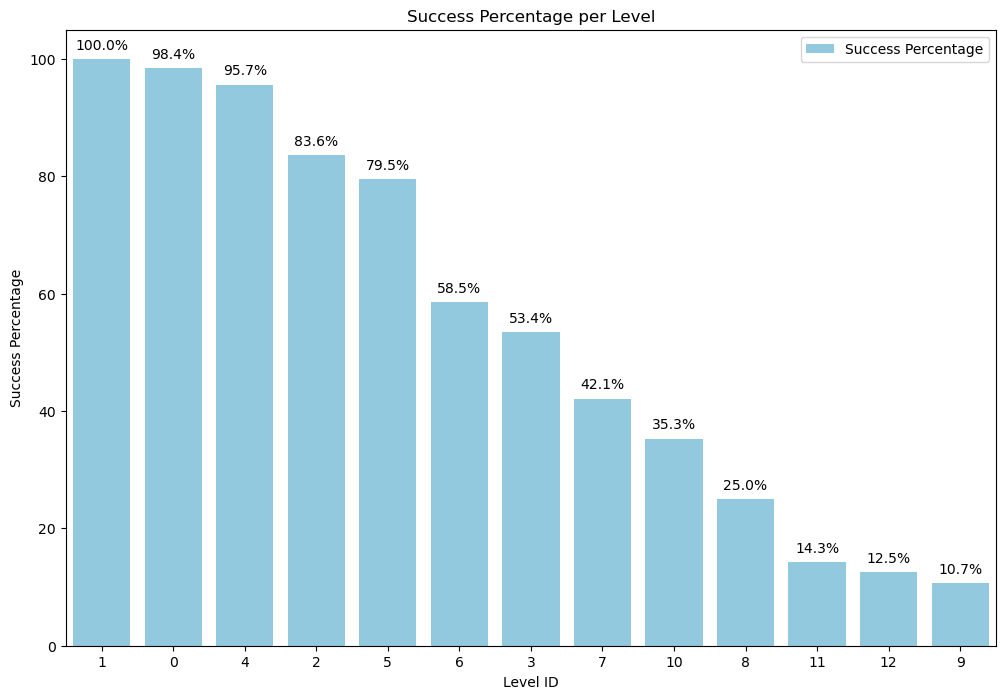

In [102]:

df_per_level = df.sort_values(by='level_id', ascending=True)


df['level_id'] = df['level_id'].astype(str)
df = df.sort_values(by='success_percentage', ascending=False)

# Create a bar plot
plt.figure(figsize=(12,8))
p1 = sns.barplot(data=df, x='level_id', y='success_percentage', color='skyblue', label='Success Percentage')

# Add percentage text on top of each bar
for p in p1.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    p1.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.legend()
plt.xlabel('Level ID')
plt.ylabel('Success Percentage')
plt.title('Success Percentage per Level')
plt.show()

## Levels ordered by median time

In [103]:
# Select entries with both end_time and start_time
valid_entries = levels_filtered.dropna(subset=['start_time', 'end_time']).copy()
valid_entries = valid_entries[valid_entries['skipped'] != 't']
valid_entries['level_id'] = valid_entries['level_id'].astype(str)

# Convert end_time and start_time to datetime
valid_entries['end_time'] = pd.to_datetime(valid_entries['end_time'])
valid_entries['start_time'] = pd.to_datetime(valid_entries['start_time'])

# Calculate completion time in seconds
valid_entries.loc[:, 'completion_time'] = (valid_entries['end_time'] - valid_entries['start_time']).dt.total_seconds()
valid_entries = valid_entries[valid_entries['completion_time'] < 1300]

median_times = valid_entries.groupby('level_id')['completion_time'].median().sort_values()

# Order your dataframe according to median_times
valid_entries['level_id'] = pd.Categorical(valid_entries['level_id'], categories=median_times.index, ordered=True)

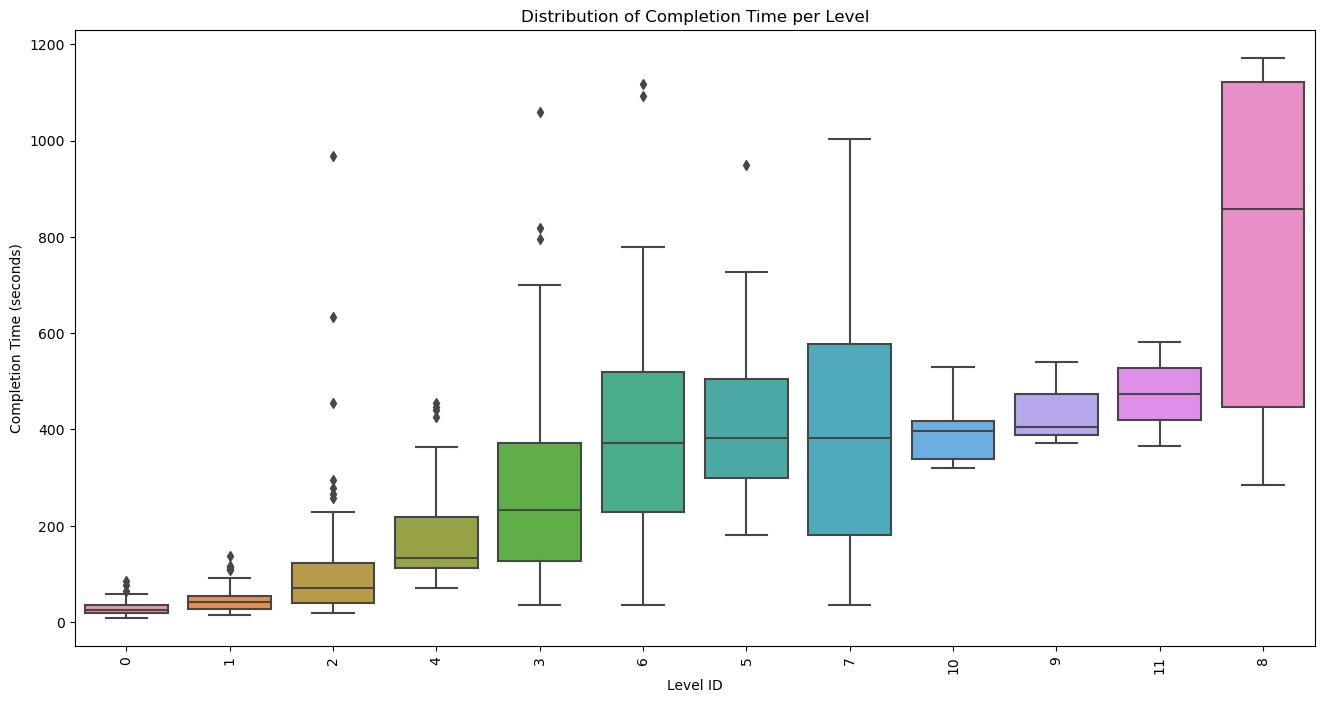

In [104]:
plt.figure(figsize=(16,8))
sns.boxplot(x='level_id', y='completion_time', data=valid_entries)
plt.xlabel('Level ID')
plt.ylabel('Completion Time (seconds)')
plt.title('Distribution of Completion Time per Level')
plt.xticks(rotation=90)  # This rotates the x-axis labels for better visibility if you have many levels
plt.show()

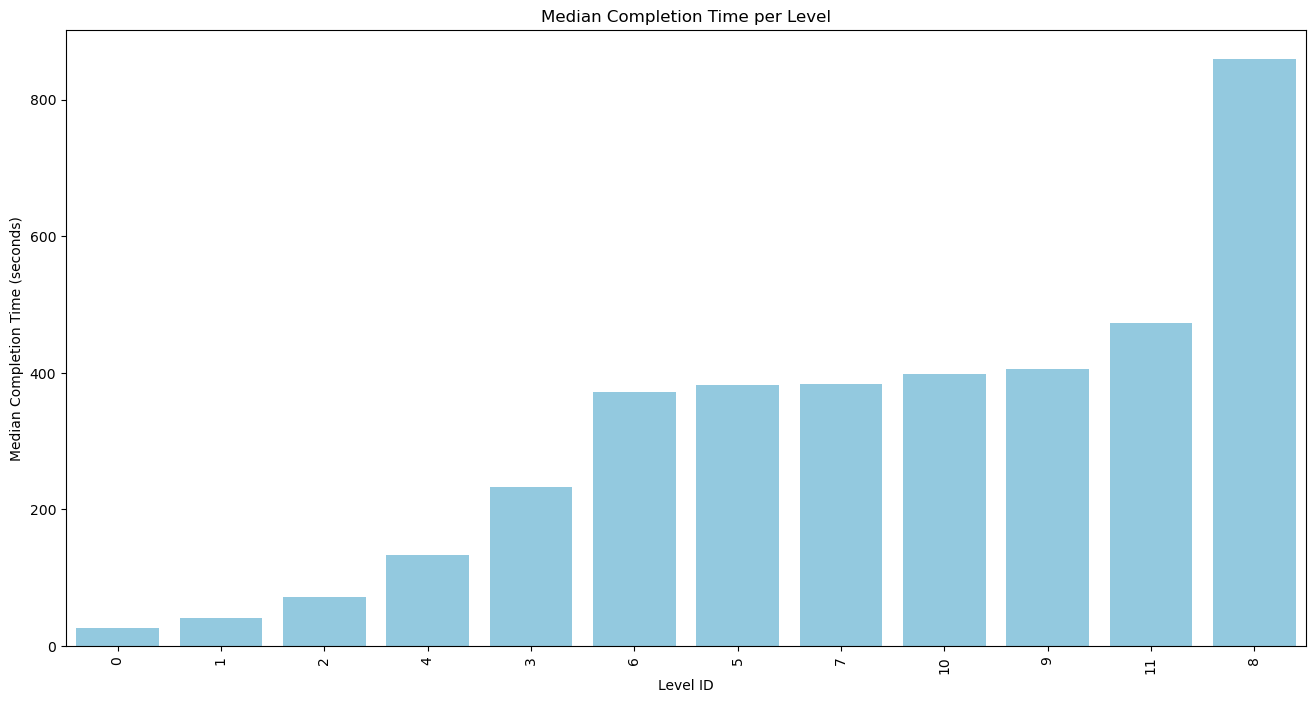

In [105]:
plt.figure(figsize=(16, 8))
sns.barplot(x=median_times.index, y=median_times.values, color='skyblue')
plt.xlabel('Level ID')
plt.ylabel('Median Completion Time (seconds)')
plt.title('Median Completion Time per Level')
plt.xticks(rotation=90)  # This rotates the x-axis labels for better visibility if you have many levels
plt.show()

## Player progression stats

In [106]:
# Filter the dataframe
completed_levels = levels_filtered[(~levels_filtered['start_time'].isna()) & 
                                   (~levels_filtered['end_time'].isna()) & 
                                   (levels_filtered['skipped'] == 'f')]

# Calculate completed levels per game
completed_levels_per_game = completed_levels.groupby('game_id').size()

average_levels = completed_levels_per_game.mean()
median_levels = completed_levels_per_game.median()

print(f"Average completed levels per player: {average_levels}")
print(f"Median completed levels per player: {median_levels}")
print("\n")

print(f"Total number of games: {len(games_filtered)}")
print(f"Number of games with 1 level completed: {len(completed_levels_per_game[completed_levels_per_game == 1])}")
print(f"Number of games with 2 levels completed: {len(completed_levels_per_game[completed_levels_per_game == 2])}")
print(f"Number of games with 3 levels completed: {len(completed_levels_per_game[completed_levels_per_game == 3])}")
print(f"Number of games with at least 4 levels completed: {len(completed_levels_per_game[(completed_levels_per_game >= 4)])}")

print("\n")
print(f"Most successful players and their number of levels completed:\n {completed_levels_per_game.sort_values(ascending=False).head(5)}");

# List all ids of games with 1 levels completed
games_with_1_level = completed_levels_per_game[completed_levels_per_game == 1].index.values

print(games_with_1_level)







Average completed levels per player: 5.564516129032258
Median completed levels per player: 5.5


Total number of games: 63
Number of games with 1 level completed: 1
Number of games with 2 levels completed: 5
Number of games with 3 levels completed: 12
Number of games with at least 4 levels completed: 44


Most successful players and their number of levels completed:
 game_id
317    12
311    12
253    11
312    10
309     9
dtype: int64
[281]


# Comparison to player robozzle scores

In [107]:
# pull in robozzle.csv
robozzle = pd.read_csv('sprint.csv')
robozzle = robozzle[['nationalid', 'selectionsprintxp', 'zzzlegamelastlevel']]
robozzle = robozzle.dropna(subset=['nationalid'])
robozzle = robozzle.sort_values(by='zzzlegamelastlevel', ascending=False).drop_duplicates(subset='nationalid', keep='first')


games_filtered = games_filtered.merge(robozzle, left_on='id_code', right_on='nationalid')


completed_levels['level_id'] = completed_levels['level_id'].astype(int)

df_scores = completed_levels.groupby('game_id').size().reset_index()
df_scores.columns = ['id', 'sokoban_score']

df_scores.rename(columns={'game_id': 'id'}, inplace=True)

df_games = pd.merge(games_filtered, df_scores, on='id', how='left')




/var/folders/8c/yrvqm8rj3qq9fnfdh4829syc0000gn/T/ipykernel_4374/3291081615.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_levels['level_id'] = completed_levels['level_id'].astype(int)


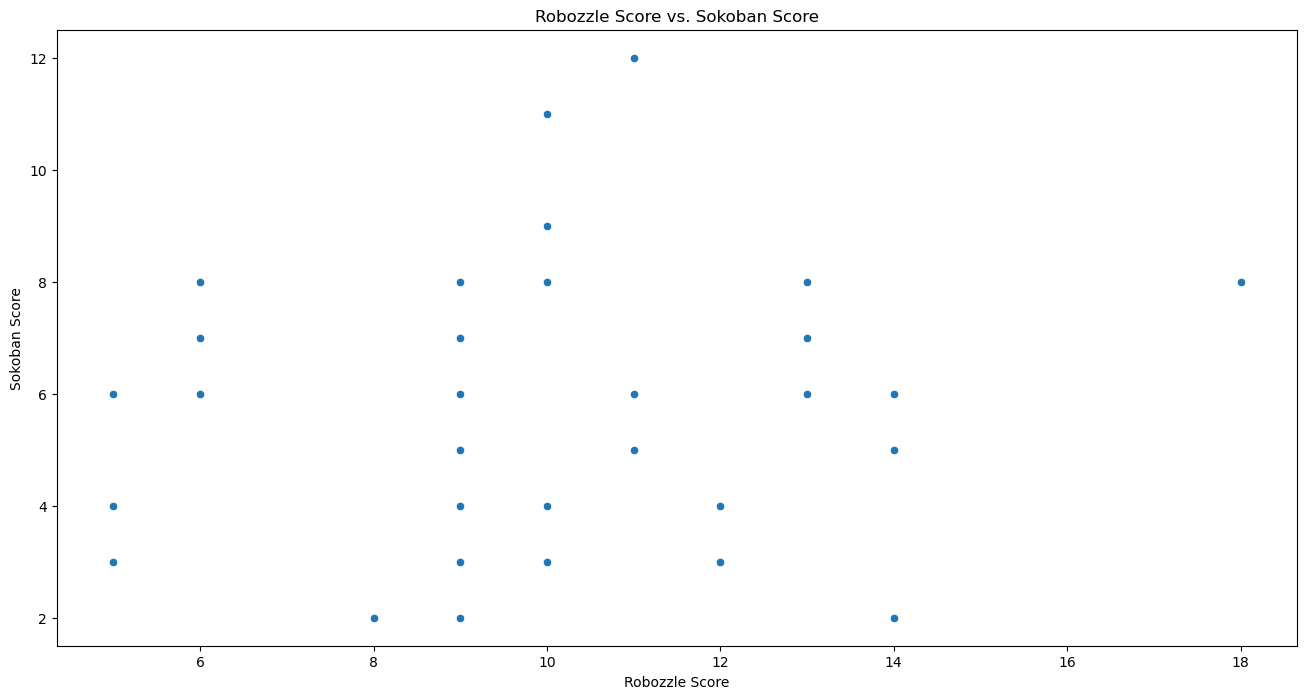

In [108]:
# plot zzzlegamelastlevel from df_games against sokoban_score

plt.figure(figsize=(16, 8))
sns.scatterplot(x='zzzlegamelastlevel', y='sokoban_score', data=df_games)
plt.xlabel('Robozzle Score')
plt.ylabel('Sokoban Score')
plt.title('Robozzle Score vs. Sokoban Score')
plt.show()


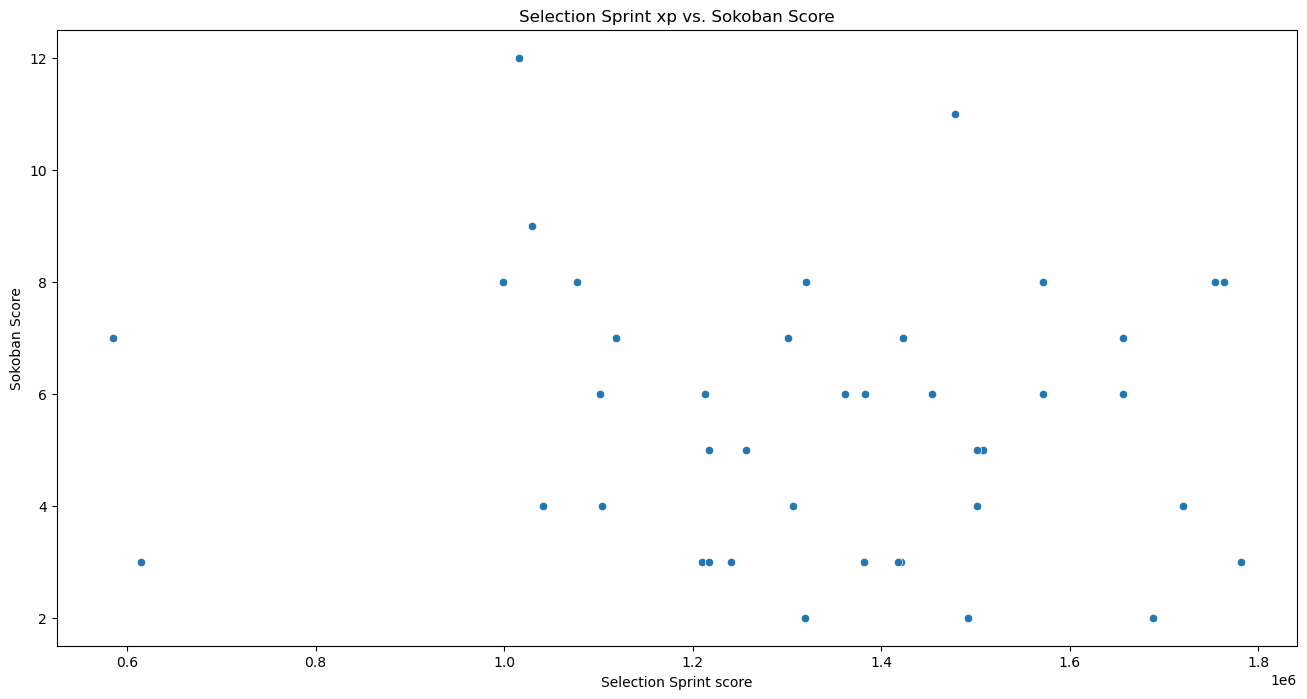

In [109]:
# # plot selectionsprintxp from df_games against sokoban_score

plt.figure(figsize=(16, 8))
sns.scatterplot(x='selectionsprintxp', y='sokoban_score', data=df_games)
plt.xlabel('Selection Sprint score')
plt.ylabel('Sokoban Score')
plt.title('Selection Sprint xp vs. Sokoban Score')
plt.show()

In [110]:
# Pearson correlation coefficient

print(f"Pearson correlation coefficient between Robozzle score and Sokoban score: {df_games['zzzlegamelastlevel'].corr(df_games['sokoban_score'])}")

print(f"Pearson correlation coefficient between Selection Sprint score and Sokoban score: {df_games['selectionsprintxp'].corr(df_games['sokoban_score'])}")


# Calclate spearman for both too

print(f"Spearman correlation coefficient between Robozzle score and Sokoban score: {df_games['zzzlegamelastlevel'].corr(df_games['sokoban_score'], method='spearman')}")
print(f"Spearman correlation coefficient between Selection Sprint score and Sokoban score: {df_games['selectionsprintxp'].corr(df_games['sokoban_score'], method='spearman')}")

Pearson correlation coefficient between Robozzle score and Sokoban score: 0.02294595473279517
Pearson correlation coefficient between Selection Sprint score and Sokoban score: -0.03999413908463269
Spearman correlation coefficient between Robozzle score and Sokoban score: 0.009283964149837273
Spearman correlation coefficient between Selection Sprint score and Sokoban score: -0.020113276617361144
